# Step 1: Set up the Environment

In [3]:
# Load the required libraries
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the Data

In [4]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# Limiting the dataset to the first 10,000 images for training and testing due to computational limitations
n = 10000
train_images, train_labels = train_images[:n], train_labels[:n]
test_images, test_labels = test_images[:n], test_labels[:n]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Step 3: Data Preprocessing

In [5]:
# Preprocess the data
def preprocess_image(image):
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
    return image

train_images_resized = np.array([preprocess_image(img) for img in train_images])
test_images_resized = np.array([preprocess_image(img) for img in test_images])

train_images_preprocessed = preprocess_input(train_images_resized.astype(np.float32))
test_images_preprocessed = preprocess_input(test_images_resized.astype(np.float32))

In [6]:
# Train/Validation Split
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42)

# Step 4: Building and Compiling a Transfer Learning Model with ResNet50

In [7]:
# Build the model
inputs = Input(shape=(64, 64, 3))

# Augmentation should be applied after resizing
x_resized = layers.Resizing(224, 224)(inputs)

# Augmentation layers
x_aug = layers.RandomFlip("horizontal")(x_resized)
x_aug = layers.RandomRotation(0.1)(x_aug)
x_aug = layers.RandomZoom(0.1)(x_aug)

# Base ResNet50 model with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x_aug)
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 224, 224, 3)    │              0 │ resizing[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 224, 224, 3)    │              0 │ random_flip[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom (RandomZoom)  │ (None, 224, 224, 3)    │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ random_zoom[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 24,155,850 (92.15 MB)

 Trainable params: 567,242 (2.16 MB)

 Non-trainable params: 23,588,608 (89.98 MB)

# Step 6: Train the Model

In [ ]:
# Define callbacks to stop early and reduce learning rate on plateaus
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
    CSVLogger('resnet50_training_log.csv', append=False),  # This saves your training logs
    ModelCheckpoint('resnet50_phase1_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

# Initial Training
history = model.fit(
    train_imgs, train_lbls,
    validation_data=(val_imgs, val_lbls),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

In [29]:
# Training Logs for 10 Epochs before finetuning
import pandas as pd
x=pd.read_csv('/resnet50_training_log.csv')
x.head(10)

,epoch,accuracy,learning_rate,loss,val_accuracy,val_loss
0,0,0.309000,0.0001,7.395863,0.715,5.711358
1,1,0.520667,0.0001,6.242517,0.804,5.247254
2,2,0.607667,0.0001,5.687798,0.824,4.883497
3,3,0.659111,0.0001,5.260336,0.836,4.555830
4,4,0.692000,0.0001,4.896137,0.859,4.232170
5,5,0.717556,0.0001,4.549094,0.864,3.942338
6,6,0.736333,0.0001,4.227860,0.870,3.656559
7,7,0.749000,0.0001,3.932747,0.868,3.391130
8,8,0.763111,0.0001,3.649642,0.888,3.159842
9,9,0.767000,0.0001,3.418844,0.879,2.937740


In [ ]:
# Load pre-fine-tuned model
model = load_model('/resnet50_phase1_best.h5')

In [11]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Accuracy before fine tune: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1855s 6s/step - accuracy: 0.8615 - loss: 3.0072
Test Accuracy before fine tune: 0.8614


# Step 7: Finetune the Model

In [12]:
# Callbacks for fine-tuning
callbacks_finetune = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    CSVLogger('resnet50_finetune_log.csv', append=True),
    ModelCheckpoint('resnet50_cifar10_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# Fine-tuning: Unfreeze selected Conv2D layers
for layer in base_model.layers:
    if isinstance(layer, Conv2D):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(train_imgs, train_lbls,
                       validation_data=(val_imgs, val_lbls),
                       epochs=3, batch_size=32, # 3 epochs only due to long training time
                       callbacks=callbacks_finetune)

In [31]:
# Training Logs for 3 Epochs after finetuning
import pandas as pd
x=pd.read_csv('/content/resnet50_finetune_log.csv')
x.head()

,epoch,accuracy,learning_rate,loss,val_accuracy,val_loss
0,0,0.785111,0.00001,3.224405,0.887,2.878208
1,1,0.792778,0.00001,3.168460,0.888,2.840990
2,2,0.793556,0.00001,3.136008,0.893,2.804298


In [ ]:
# Final save
model.save('resnet50_cifar10_finetuned_final.h5')

# Step 8: Evaluate the Model

In [30]:
# Evaluate fine-tuned model on the test set
test_loss_ft, test_acc_ft = model.evaluate(test_images_preprocessed, test_labels)
print(f"Test Accuracy after fine-tuning: {test_acc_ft:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1936s 6s/step - accuracy: 0.8680 - loss: 2.8772
Test Accuracy after fine-tuning: 0.8681


# Step 9: Plot Accuracy & Loss Curves

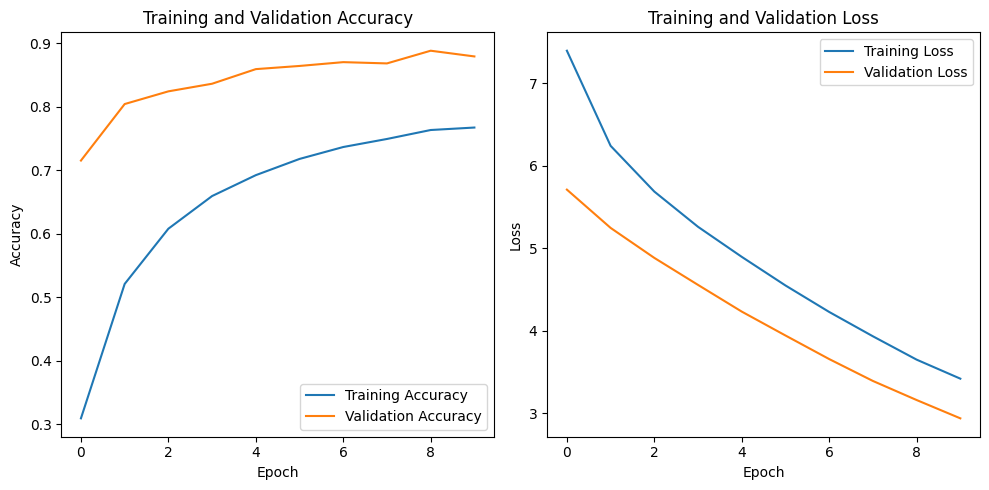

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv('/resnet50_training_log.csv')
except FileNotFoundError:
    print("Error: The file 'resnet50_training_log.csv' was not found.")
    exit()

# --- Plotting Accuracy Curves ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['accuracy'], label='Training Accuracy')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# --- Plotting Loss Curves ---
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
# Note that longer training can be done for better convergence

# Step 10: Evaluating Model Performance: Classification Report and Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1852s 6s/step
Classification Report:

              precision    recall  f1-score   support

           0     0.8547    0.9060    0.8796      1000
           1     0.9285    0.9350    0.9317      1000
           2     0.8627    0.8040    0.8323      1000
           3     0.8157    0.6950    0.7505      1000
           4     0.8161    0.8520    0.8337      1000
           5     0.8172    0.8540    0.8352      1000
           6     0.8611    0.9240    0.8915      1000
           7     0.8913    0.8860    0.8887      1000
           8     0.9103    0.9130    0.9116      1000
           9     0.9212    0.9120    0.9166      1000

    accuracy                         0.8681     10000
   macro avg     0.8679    0.8681    0.8671     10000
weighted avg     0.8679    0.8681    0.8671     10000



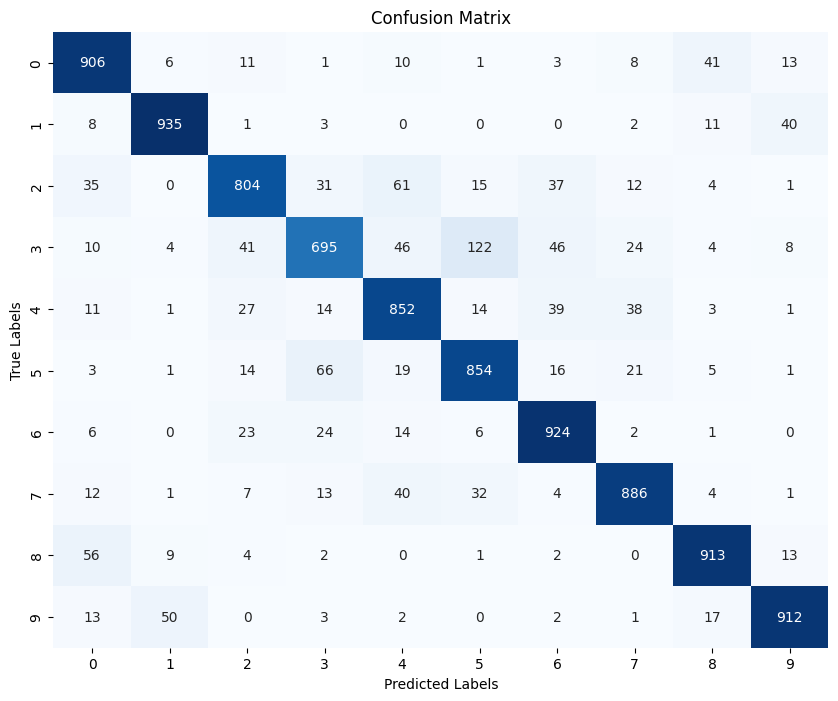

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get model predictions
y_pred_probs = model.predict(test_images_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Classification Report
print("Classification Report:\n")
print(classification_report(test_labels, y_pred, digits=4))

# Step 3: Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_labels = [
    'airplane',   # 0
    'automobile', # 1
    'bird',       # 2
    'cat',        # 3
    'deer',       # 4
    'dog',        # 5
    'frog',       # 6
    'horse',      # 7
    'ship',       # 8
    'truck'       # 9
    ]

# Step 11: Prediction vs Ground Truth on CIFAR-10 Sample

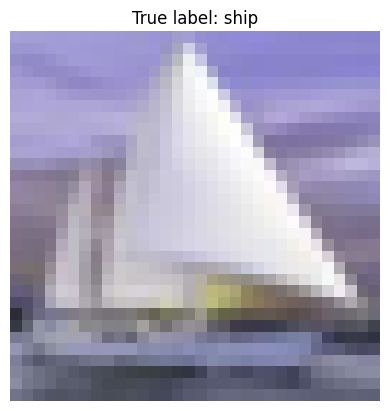

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
True label: ship
Predicted class: ship


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# Class labels for CIFAR-10
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

# Select a random test image and label
random_index = np.random.randint(0, len(test_images))
img = test_images[random_index]
true_label = test_labels[random_index]

# Ensure true_label is an integer
true_label = int(true_label)

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"True label: {class_labels[true_label]}")
plt.show()

# Preprocess: Resize to 64x64 (if needed) and apply ResNet50 preprocessing
img_resized = tf.image.resize(img, [64, 64])
img_preprocessed = preprocess_input(img_resized.numpy().astype(np.float32))
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)  # Add batch dimension

# Predict using the model
predictions = model.predict(img_preprocessed)
predicted_class = np.argmax(predictions, axis=1)[0]

# Display predicted and true label
print(f"True label: {class_labels[true_label]}")
print(f"Predicted class: {class_labels[predicted_class]}")